In [2]:
import numpy as np

# Generate synthetic dataset
np.random.seed(42)
N = 100  # number of samples
L = 5    # number of locations
K = 3    # number of clades

# Randomly generate data
y = np.random.randint(1, K+1, size=N)
ll = np.random.randint(1, L+1, size=N)
x = np.random.normal(size=N)
weights = np.random.randint(0, 2, size=N)  # include some 0 counts

In [3]:
y

array([3, 1, 3, 3, 1, 1, 3, 2, 3, 3, 3, 3, 1, 3, 2, 1, 2, 2, 2, 2, 1, 1,
       2, 2, 1, 1, 1, 3, 3, 3, 2, 3, 2, 2, 3, 2, 3, 3, 1, 3, 1, 3, 3, 1,
       1, 3, 2, 1, 2, 2, 2, 1, 2, 1, 2, 3, 3, 1, 3, 3, 2, 1, 2, 2, 2, 2,
       2, 2, 2, 1, 3, 2, 2, 2, 2, 2, 2, 3, 3, 2, 3, 1, 2, 1, 1, 2, 3, 1,
       2, 1, 1, 1, 1, 3, 1, 1, 1, 3, 1, 1])

In [4]:
ll

array([4, 3, 3, 1, 3, 3, 1, 3, 5, 2, 2, 1, 4, 1, 4, 2, 1, 5, 3, 4, 3, 3,
       1, 3, 5, 3, 1, 5, 2, 3, 1, 2, 2, 4, 5, 3, 1, 4, 5, 4, 5, 5, 3, 5,
       4, 5, 3, 3, 4, 2, 2, 5, 1, 5, 4, 4, 4, 4, 4, 3, 2, 4, 1, 1, 1, 1,
       3, 1, 4, 5, 1, 3, 3, 1, 5, 1, 3, 2, 4, 3, 1, 4, 1, 1, 2, 4, 4, 2,
       3, 1, 5, 1, 1, 3, 1, 2, 2, 4, 5, 1])

In [5]:
x

array([ 1.43351549,  1.06579371, -2.49875914,  1.48032856,  2.15872852,
        1.23177838, -0.21432448, -0.68919421,  0.72783311, -0.61906936,
        0.35615983, -0.02188087,  1.21805044, -0.38945802, -0.44280234,
        0.37822661,  1.9338398 ,  0.08097081, -0.41645636,  0.85750325,
        0.71812828, -0.95147175, -0.5361601 ,  1.09652886,  0.42801284,
       -2.46969887,  0.48197914,  0.92645636, -0.83758139,  0.67718607,
        1.87231912,  0.39637394, -0.6256163 , -0.52246148,  0.0130339 ,
        0.37776959,  0.0628246 ,  0.50159637, -0.14694539,  0.18062297,
        0.96481058, -1.06483115,  0.1087118 ,  0.10576365,  0.92066672,
       -0.22672246,  0.65304831,  1.10268747, -1.84980294,  1.16863124,
       -0.9853818 , -1.09394041, -2.87945689, -0.80317767, -0.00485694,
       -0.38332331, -0.46252686, -1.11249735,  0.8672295 ,  0.95841384,
        0.41811852, -1.88652805,  2.27334516,  0.14697465,  0.5396092 ,
       -1.49829564, -0.01144345,  0.41335409, -0.14089855,  0.87

In [6]:
weights

array([0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0])

In [7]:
import pymc as pm

with pm.Model() as model:
    # Priors
    bsd = pm.Normal('bsd', mu=1, sigma=0.1)
    bloc = pm.Normal('bloc', mu=0, sigma=0.2, shape=(K-1,))
    
    raw_alpha = pm.Normal('raw_alpha', mu=0, sigma=6, shape=(L, K-1))
    raw_beta = pm.Normal('raw_beta', mu=bloc, sigma=bsd, shape=(L, K-1))
    
    # Append zero for reference variant
    alpha = pm.Deterministic('alpha', pm.math.concatenate([pm.math.zeros((L, 1)), raw_alpha], axis=1))
    beta = pm.Deterministic('beta', pm.math.concatenate([pm.math.zeros((L, 1)), raw_beta], axis=1))
    
    # Likelihood
    logit_p = alpha[ll-1] + beta[ll-1] * x[:, None]
    y_obs = pm.Categorical('y_obs', p=pm.math.softmax(logit_p), observed=y-1)
    
    # Weighted log-probability
    log_prob = pm.math.log(pm.math.sum(pm.math.exp(logit_p), axis=1))
    weighted_log_prob = weights * log_prob
    
    # Add to target log-probability
    pm.Potential('weighted_log_prob', weighted_log_prob.sum())

# Sample from the posterior
with model:
    trace = pm.sample(1000, tune=1000, return_inferencedata=False)

# Print summary of the trace
pm.summary(trace).round(2)

Initializing NUTS using jitter+adapt_diag...


SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'bsd': array(1.87223691), 'bloc': array([0.22283069, 0.20289582]), 'raw_alpha': array([[ 0.36005141,  0.72398945],
       [ 0.96032428, -0.45811712],
       [-0.17493322,  0.57588649],
       [-0.8448849 ,  0.9776675 ],
       [-0.48720699, -0.58669532]]), 'raw_beta': array([[ 0.47619981,  0.35857826],
       [-0.72513917,  0.40732908],
       [ 0.40338387, -0.36460571],
       [ 0.79995568,  1.11598447],
       [ 0.31406079,  0.22306452]])}

Logp initial evaluation results:
{'bsd': -36.66, 'bloc': 0.25, 'raw_alpha': -27.17, 'raw_beta': -15.83, 'y_obs': -inf, 'weighted_log_prob': 69.48}
You can call `model.debug()` for more details.

In [8]:
model.debug()

point={'bsd': array(1.), 'bloc': array([0., 0.]), 'raw_alpha': array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]]), 'raw_beta': array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])}



TypeError: TensorType does not support iteration.
	Did you pass a PyTensor variable to a function that expects a list?
	Maybe you are using builtins.sum instead of pytensor.tensor.sum?

In [17]:
import numpy as np
import pymc as pm

# Generate synthetic dataset
np.random.seed(42)
N = 100  # number of samples
L = 5    # number of locations
K = 3    # number of clades

# Randomly generate data
y = np.random.randint(1, K+1, size=N)
ll = np.random.randint(1, L+1, size=N)
x = np.random.randint(0, 30, size=N)  # days as integer values
weights = np.random.randint(0, 2, size=N)  # include some 0 counts


# pymc model

with pm.Model() as model:
    # Priors
    bsd = pm.Normal('bsd', mu=1, sigma=2)
    bloc = pm.Normal('bloc', mu=0, sigma=2, shape=(K-1,))
    
    raw_alpha = pm.Normal('raw_alpha', mu=0, sigma=2, shape=(L, K-1))
    raw_beta = pm.Normal('raw_beta', mu=bloc, sigma=bsd, shape=(L, K-1))
    
    # Append zero for reference variant
    alpha = pm.Deterministic('alpha', pm.math.concatenate([pm.math.zeros((L, 1)), raw_alpha], axis=1))
    beta = pm.Deterministic('beta', pm.math.concatenate([pm.math.zeros((L, 1)), raw_beta], axis=1))
    
    # Likelihood
    logit_p = alpha[ll-1] + beta[ll-1] * x[:, None]
    y_obs = pm.Categorical('y_obs', logit_p=pm.math.softmax(logit_p), observed=y-1)
    
    # Weighted log-probability
    log_prob = pm.math.log(pm.math.sum(pm.math.exp(logit_p), axis=1))
    weighted_log_prob = weights * log_prob
    
    # Add to target log-probability
    pm.Potential('weighted_log_prob', weighted_log_prob.sum())

# Sample from the posterior
with model:
    trace = pm.sample(1000, tune=1000, return_inferencedata=True)

# Print summary of the trace
pm.summary(trace).round(2)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bsd, bloc, raw_alpha, raw_beta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.
There were 3999 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
/opt/anaconda3/envs/asper_pymc/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/anaconda3/envs/asper_pymc/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_sampl

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bsd,4.14,0.26,3.85,4.45,0.13,0.10,4.0,13.0,3.44
bloc[0],0.67,1.03,-0.72,2.16,0.51,0.39,4.0,12.0,4.16
bloc[1],0.75,1.22,-1.18,1.91,0.61,0.47,4.0,11.0,3.86
"raw_alpha[0, 0]",0.77,1.28,-0.89,2.24,0.64,0.49,4.0,12.0,3.26
"raw_alpha[0, 1]",1.58,0.69,0.53,2.45,0.34,0.26,4.0,11.0,3.58
"raw_alpha[1, 0]",0.42,0.56,-0.48,1.09,0.28,0.21,5.0,23.0,3.20
"raw_alpha[1, 1]",0.59,0.70,-0.48,1.34,0.35,0.27,5.0,30.0,3.12
"raw_alpha[2, 0]",0.92,1.13,-0.41,2.20,0.56,0.43,4.0,11.0,3.40
"raw_alpha[2, 1]",1.16,1.06,-0.19,2.36,0.53,0.40,4.0,11.0,3.71
"raw_alpha[3, 0]",0.44,0.91,-0.86,1.70,0.45,0.34,4.0,13.0,3.40


In [14]:
import arviz as az

/opt/anaconda3/envs/asper_pymc/lib/python3.12/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/opt/anaconda3/envs/asper_pymc/lib/python3.12/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


array([[<Axes: title={'center': 'bsd'}>, <Axes: title={'center': 'bsd'}>],
       [<Axes: title={'center': 'bloc'}>,
        <Axes: title={'center': 'bloc'}>],
       [<Axes: title={'center': 'raw_alpha'}>,
        <Axes: title={'center': 'raw_alpha'}>],
       [<Axes: title={'center': 'raw_beta'}>,
        <Axes: title={'center': 'raw_beta'}>],
       [<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>]], dtype=object)

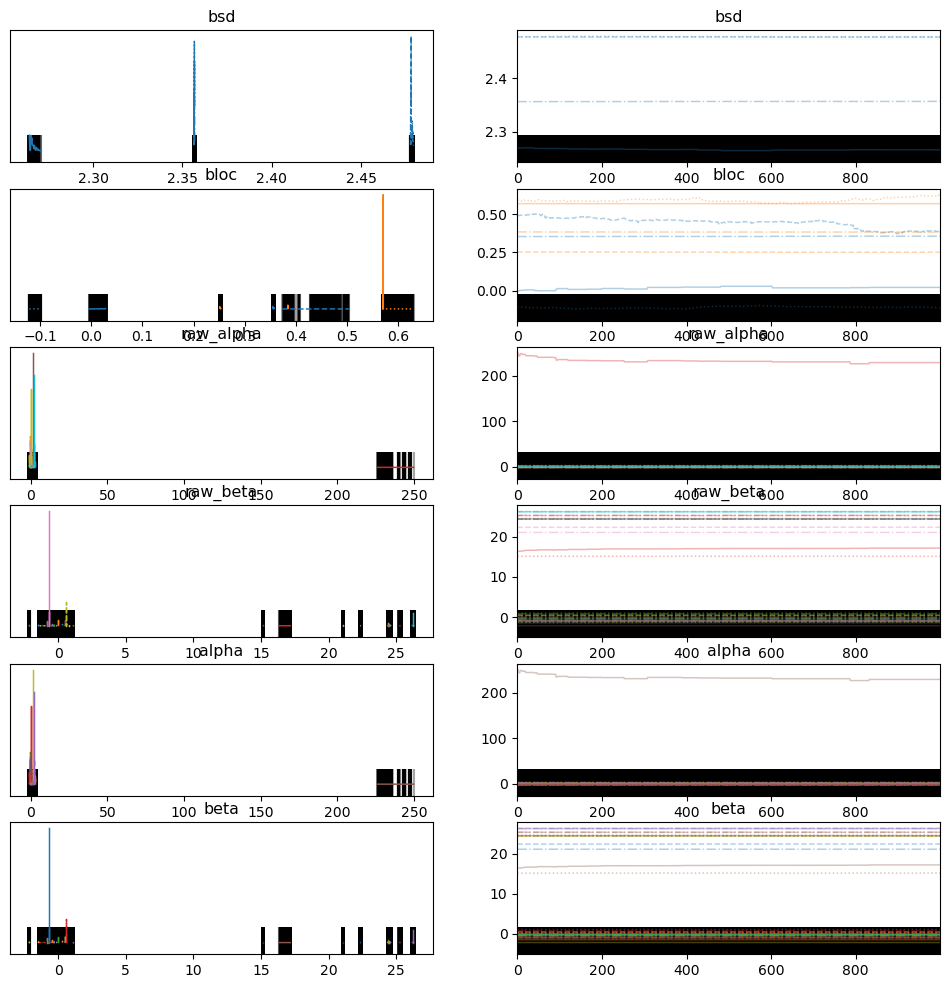

In [15]:
az.plot_trace(trace)

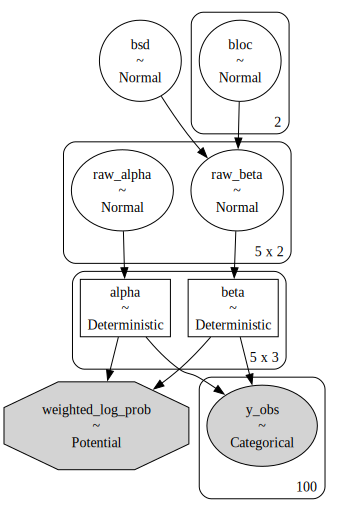

In [14]:
model.to_graphviz()

In [11]:
model.initial_point()

{'bsd': array(1.),
 'bloc': array([0., 0.]),
 'raw_alpha': array([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]]),
 'raw_beta': array([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]])}

In [12]:
model.named_vars

{'bsd': bsd,
 'bloc': bloc,
 'raw_alpha': raw_alpha,
 'raw_beta': raw_beta,
 'alpha': alpha,
 'beta': beta,
 'y_obs': y_obs,
 'weighted_log_prob': weighted_log_prob}

/opt/anaconda3/envs/asper_pymc/lib/python3.12/site-packages/arviz/plots/plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (212) in plot_autocorr, generating only 40 plots
  warnings.warn(


array([[<Axes: title={'center': 'bsd\n0'}>,
        <Axes: title={'center': 'bsd\n1'}>,
        <Axes: title={'center': 'bsd\n2'}>,
        <Axes: title={'center': 'bsd\n3'}>],
       [<Axes: title={'center': 'bloc\n0, 0'}>,
        <Axes: title={'center': 'bloc\n0, 1'}>,
        <Axes: title={'center': 'bloc\n1, 0'}>,
        <Axes: title={'center': 'bloc\n1, 1'}>],
       [<Axes: title={'center': 'bloc\n2, 0'}>,
        <Axes: title={'center': 'bloc\n2, 1'}>,
        <Axes: title={'center': 'bloc\n3, 0'}>,
        <Axes: title={'center': 'bloc\n3, 1'}>],
       [<Axes: title={'center': 'raw_alpha\n0, 0, 0'}>,
        <Axes: title={'center': 'raw_alpha\n0, 0, 1'}>,
        <Axes: title={'center': 'raw_alpha\n0, 1, 0'}>,
        <Axes: title={'center': 'raw_alpha\n0, 1, 1'}>],
       [<Axes: title={'center': 'raw_alpha\n0, 2, 0'}>,
        <Axes: title={'center': 'raw_alpha\n0, 2, 1'}>,
        <Axes: title={'center': 'raw_alpha\n0, 3, 0'}>,
        <Axes: title={'center': 'raw_alpha\n

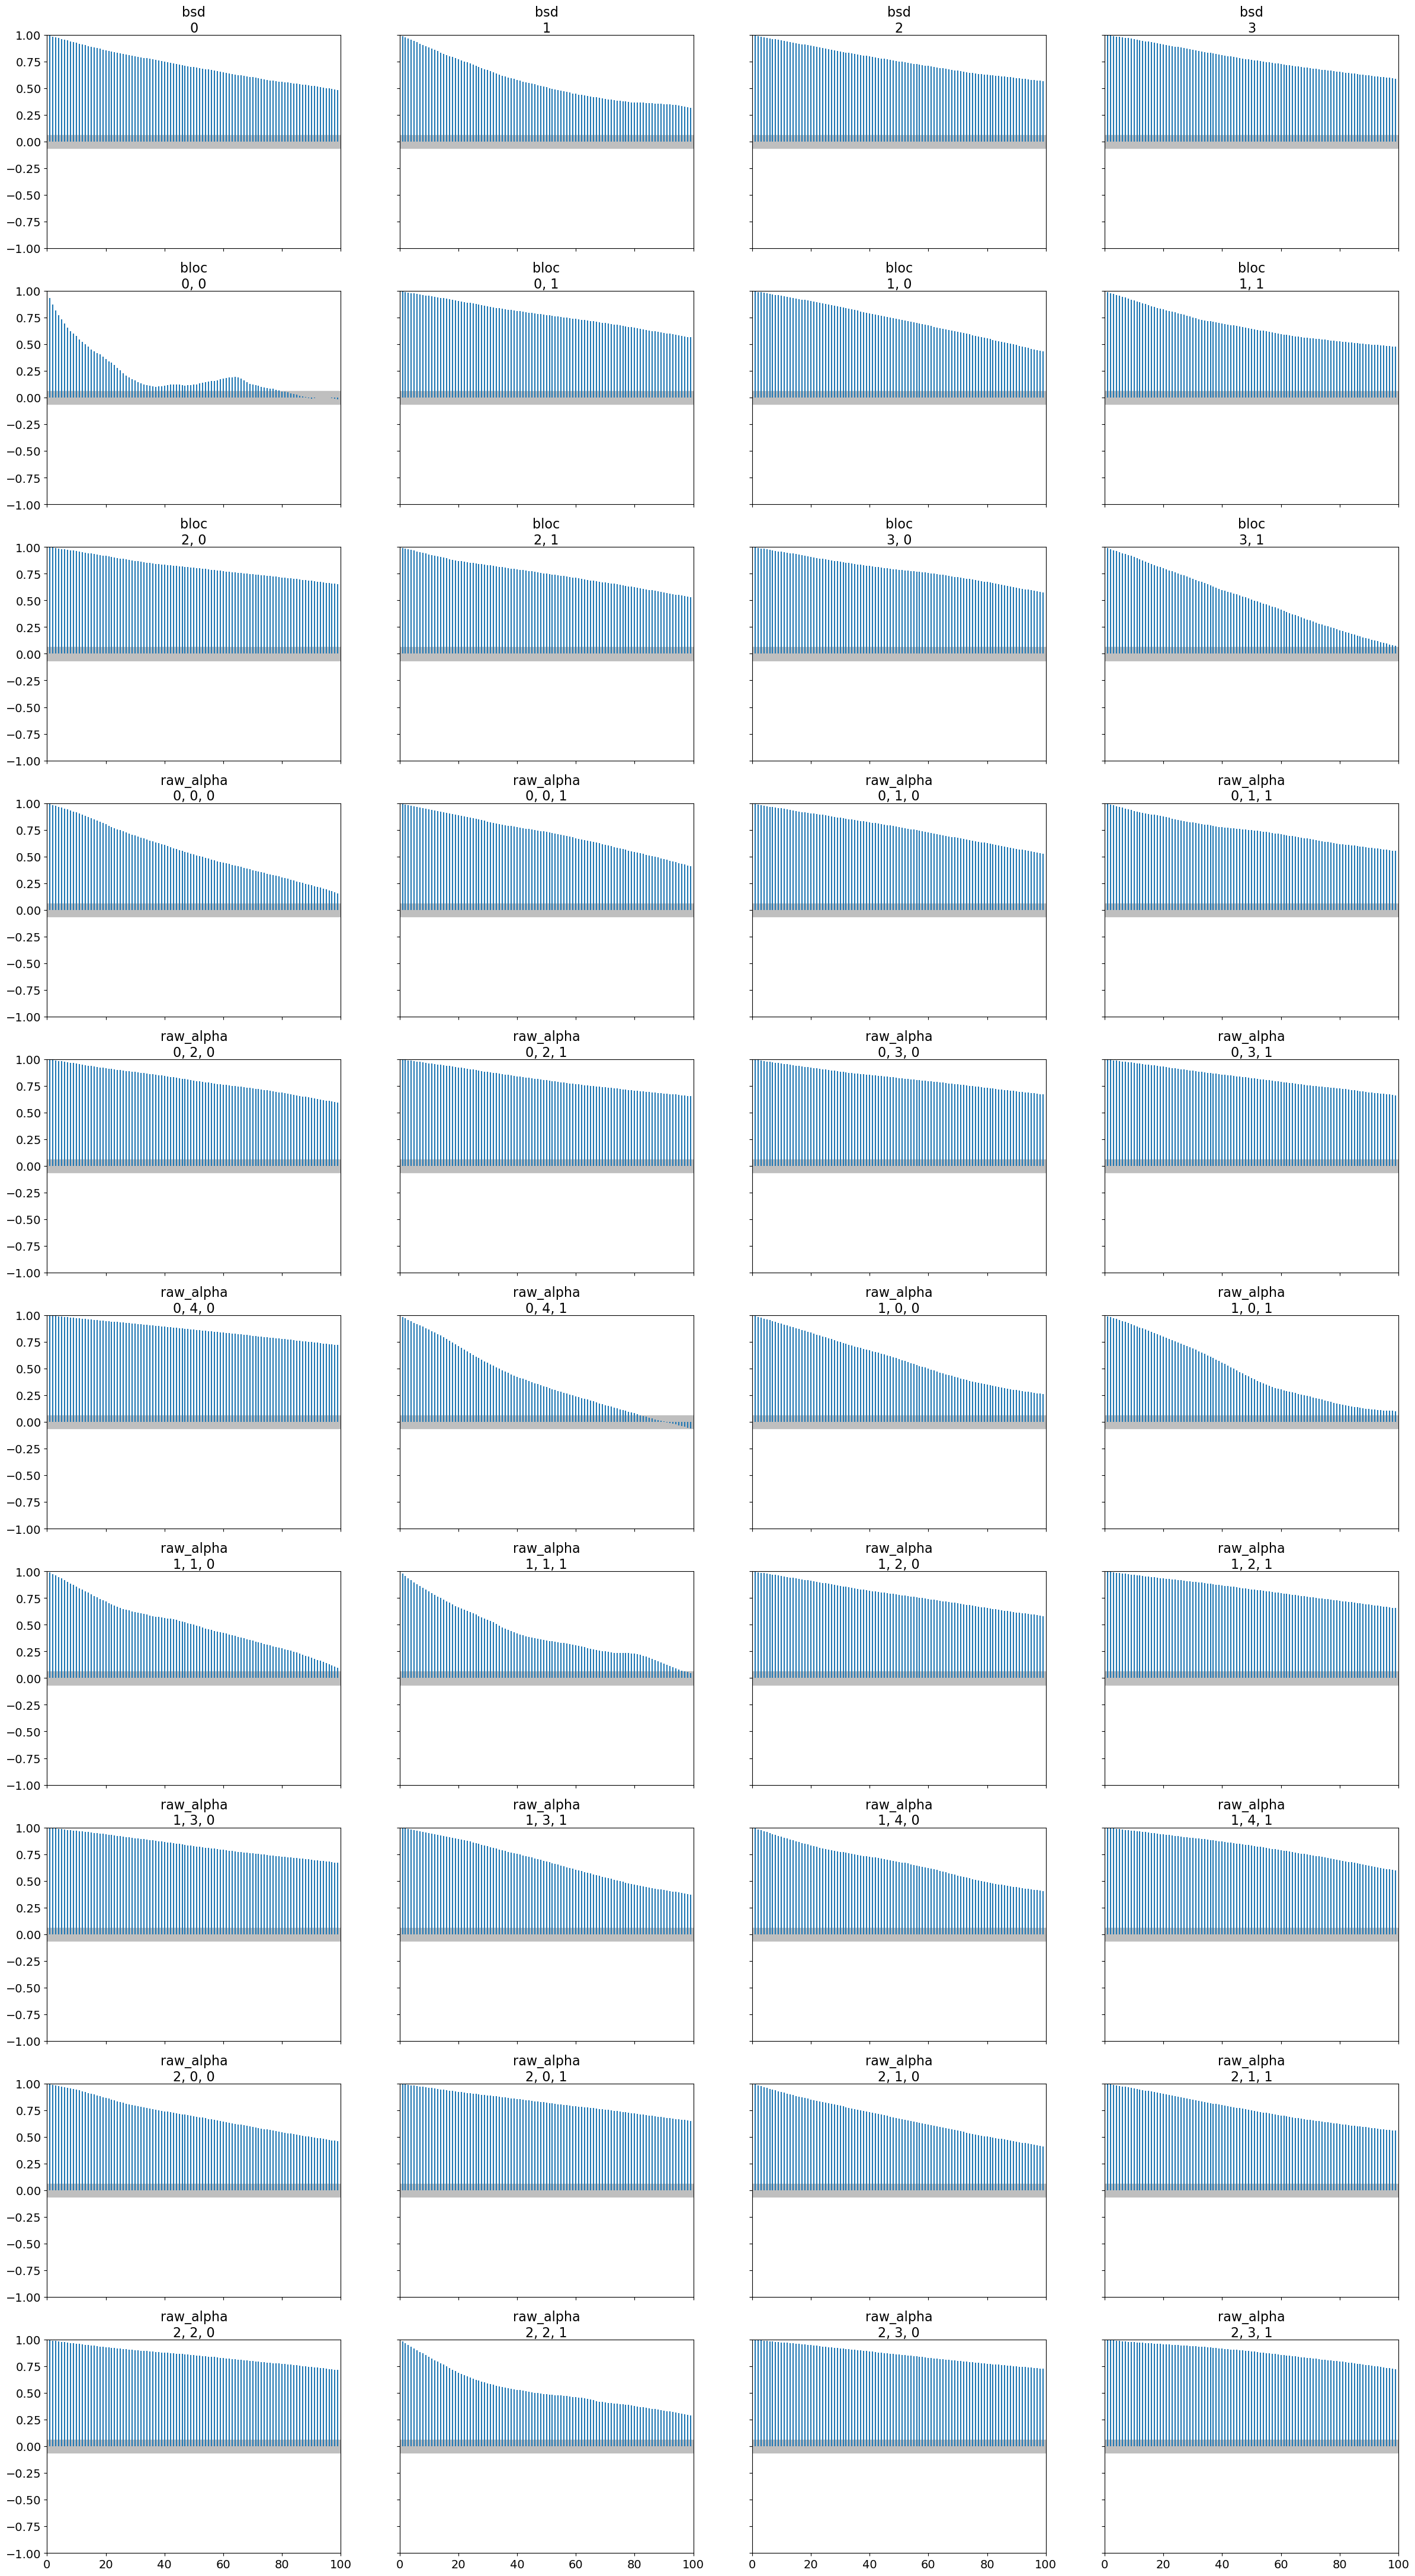

In [27]:
az.plot_autocorr(trace)

In [18]:
az.summary(trace)

/opt/anaconda3/envs/asper_pymc/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/anaconda3/envs/asper_pymc/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/anaconda3/envs/asper_pymc/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/anaconda3/envs/asper_pymc/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/anaconda3/envs/asper_pymc/lib/python3.12/site-packa

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bsd,2.273,0.118,2.074,2.390,0.058,0.045,5.0,13.0,2.90
bloc[0],0.663,0.185,0.313,0.985,0.075,0.055,7.0,15.0,1.65
bloc[1],-0.016,0.266,-0.276,0.428,0.132,0.101,4.0,12.0,3.56
"raw_alpha[0, 0]",2.006,0.513,1.170,2.597,0.256,0.196,4.0,11.0,3.26
"raw_alpha[0, 1]",-0.283,1.062,-1.575,0.920,0.529,0.405,4.0,13.0,3.31
"raw_alpha[1, 0]",1.225,0.691,0.152,2.092,0.344,0.263,4.0,12.0,3.35
"raw_alpha[1, 1]",0.791,1.315,-0.053,3.081,0.655,0.501,5.0,12.0,3.00
"raw_alpha[2, 0]",0.653,0.852,-0.625,1.792,0.424,0.325,4.0,18.0,3.97
"raw_alpha[2, 1]",0.712,1.219,-0.600,2.319,0.607,0.465,4.0,11.0,4.18
"raw_alpha[3, 0]",0.570,0.927,-0.964,1.597,0.461,0.353,4.0,11.0,4.29


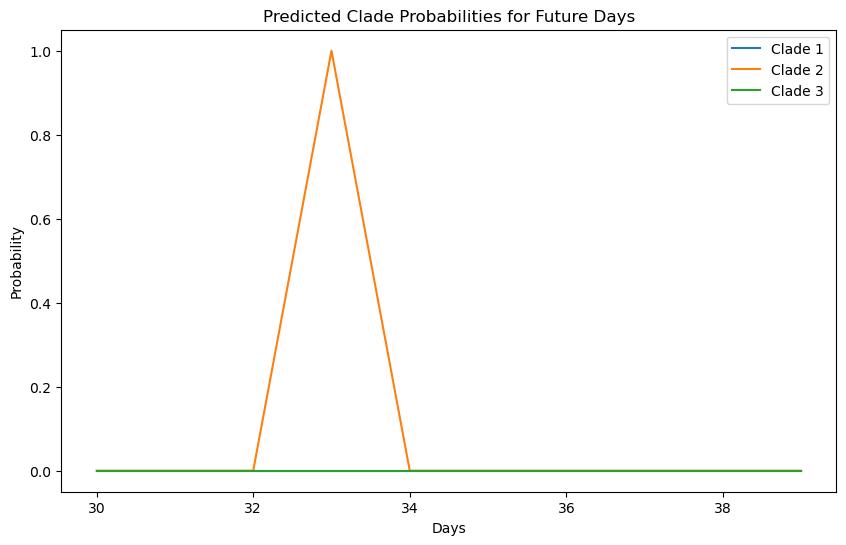

In [33]:
import matplotlib.pyplot as plt

# Make predictions up to several days in the future from the last time point
future_days = np.arange(x.max() + 1, x.max() + 11)  # predict for the next 10 days
future_ll = np.random.randint(1, L+1, size=len(future_days))  # random locations for future days

with model:
    future_logit_p = alpha[future_ll-1] + beta[future_ll-1] * future_days[:, None]
    future_probs = pm.math.softmax(future_logit_p).eval()

# Plot the predictions
fig = plt.figure(figsize=(10, 6))
for k in range(K):
    plt.plot(future_days, future_probs[:, k], label=f'Clade {k+1}')
plt.xlabel('Days')
plt.ylabel('Probability')
plt.title('Predicted Clade Probabilities for Future Days')
plt.legend()
plt.show()

# Using Hub Data

In [190]:
import polars as pl
import requests
import gzip
import shutil
import os

In [ ]:
# # Define file paths and URL
# tsv_name = "metadata.tsv"
# tsv_url = "https://data.nextstrain.org/files/ncov/open/metadata.tsv.gz"

# # Download and unzip the file if it doesn't exist
# if not os.path.exists(tsv_name):
#     response = requests.get(tsv_url)
#     with open(tsv_name + ".gz", 'wb') as f:
#         f.write(response.content)
#     with gzip.open(tsv_name + ".gz", 'rb') as f_in:
#         with open(tsv_name, 'wb') as f_out:
#             shutil.copyfileobj(f_in, f_out)

# # Read data with only the necessary columns
# dat = pl.read_csv(tsv_name, separator='\t', columns=["division", "Nextstrain_clade", "date", "date_submitted", "host"])

# # Filter by location
# state_names = ["Washington DC", "Puerto Rico"]  # Add state names as needed
# dat = dat.filter(pl.col("division").is_in(state_names))

# # Exclude any rows that have NA dates
# dat = dat.with_columns(pl.col("date").str.strptime(pl.Date, "%Y-%m-%d", strict=False))
# dat = dat.filter(pl.col("date").is_not_null())
# dat = dat.filter(pl.col("date_submitted").is_not_null())

# # Only include human specimens
# dat = dat.filter(pl.col("host") == "Homo sapiens")

# # Rename columns and exclude the host column
# dat = dat.select([
#     pl.col("division").alias("location"),
#     pl.col("Nextstrain_clade").alias("clade"),
#     pl.col("date"),
#     pl.col("date_submitted")
# ])

# # Save the filtered data to a CSV file
# dat.write_csv("metadata.csv")

# print("Data processing complete. The filtered metadata has been saved to metadata.csv.")

Data processing complete. The filtered metadata has been saved to metadata.csv.


In [458]:
# List of US states full names
us_states_full_names = [
    "Alabama", "Alaska", "Arizona", "Arkansas", "California", "Colorado", "Connecticut", 
    "Delaware", "Florida", "Georgia", "Hawaii", "Idaho", "Illinois", "Indiana", 
    "Iowa", "Kansas", "Kentucky", "Louisiana", "Maine", "Maryland", "Massachusetts", 
    "Michigan", "Minnesota", "Mississippi", "Missouri", "Montana", "Nebraska", 
    "Nevada", "New Hampshire", "New Jersey", "New Mexico", "New York", 
    "North Carolina", "North Dakota", "Ohio", "Oklahoma", "Oregon", 
    "Pennsylvania", "Rhode Island", "South Carolina", "South Dakota", 
    "Tennessee", "Texas", "Utah", "Vermont", "Virginia", 
    "Washington", "West Virginia", "Wisconsin", "Wyoming"
]

# Dictionary mapping full names to their 2 letter abbreviations
us_states_abbreviation_dict = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR', 'California': 'CA', 
    'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE', 'Florida': 'FL', 'Georgia': 'GA', 
    'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA', 
    'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 
    'Maryland': 'MD', 'Massachusetts': 'MA', 'Michigan': 'MI', 
    'Minnesota': 'MN', 'Mississippi': 'MS', 'Missouri': 'MO', 
    'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV', 
    'New Hampshire': 'NH', 'New Jersey': 'NJ', 
    'New Mexico': 'NM', 'New York': 'NY', 
    'North Carolina': 'NC', 'North Dakota': 'ND', 
    'Ohio': 'OH', 'Oklahoma': 'OK', 'Oregon': 'OR', 
    'Pennsylvania': 'PA', 'Rhode Island': 'RI', 
    'South Carolina': 'SC', 'South Dakota': 'SD', 
    'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT', 
    'Vermont': 'VT', 'Virginia': 'VA', 'Washington': 'WA', 
    'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY'
}

print("List of US States Full Names:")
print(us_states_full_names)

print("\nDictionary Mapping Full Names to 2 Letter Abbreviations:")
print(us_states_abbreviation_dict)

List of US States Full Names:
['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']

Dictionary Mapping Full Names to 2 Letter Abbreviations:
{'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR', 'California': 'CA', 'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE', 'Florida': 'FL', 'Georgia': 'GA', 'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA', 'Kansas': 'KS', 'Kentucky': '

In [460]:
df = pl.read_csv("counts_2025-02-19.tsv.gz" ,separator='\t')
df.head()

location,clade,date,sequences
str,str,str,i64
"""Afton""","""23E""","""2023-08-25""",1
"""Afton""","""23F""","""2023-08-26""",1
"""Alabama""","""19A""","""2021-07-30""",1
"""Alabama""","""19A""","""2021-08-01""",2
"""Alabama""","""19A""","""2021-08-04""",1


In [461]:
df.describe()

statistic,location,clade,date,sequences
str,str,str,str,f64
"""count""","""210365""","""210365""","""210365""",210365.0
"""null_count""","""0""","""0""","""0""",0.0
"""mean""",null,null,null,16.771421
"""std""",null,null,null,71.228218
"""min""","""Afton""","""19A""","""2020-01-01""",1.0
"""25%""",null,null,null,1.0
"""50%""",null,null,null,3.0
"""75%""",null,null,null,9.0
"""max""","""Yap""","""recombinant""","""2025-02-04""",4472.0


In [462]:
df['location'].unique()

location
str
"""Arlington"""
"""Iowa"""
"""Montana"""
"""Crozet"""
"""Un"""
…
"""Chilhowie"""
"""Nebraska"""
"""Northern Mariana Islands"""


In [463]:
df.select('clade').unique()

clade
str
"""24C"""
"""23C"""
"""22B"""
"""21G"""
"""21H"""
…
"""21L"""
"""22C"""
"""24H"""


In [464]:
len(df.select('date').unique())

1830

In [465]:
data = df.clone()
data = data.with_columns(pl.col("date").str.to_date("%Y-%m-%d"))

#locations = ['Tennessee', 'Massachusetts', 'California', 'Minnesota', 'New York', 'Texas']
locations = us_states_full_names
clades = ["24A", "24C", "24E", "24F",  "24H", "24I", "25A", "recombinant", "other"]

data = df.filter(pl.col("location").is_in(locations),
                 pl.col('clade').is_in(clades), 
                 pl.col("date") > "2024-10-01")
data.shape

(5089, 4)

In [466]:
data.head()

location,clade,date,sequences
str,str,str,i64
"""Alabama""","""24A""","""2024-12-31""",1
"""Alabama""","""24E""","""2024-10-21""",1
"""Alabama""","""24E""","""2024-10-22""",1
"""Alabama""","""24E""","""2024-12-01""",1
"""Alabama""","""24E""","""2024-12-20""",2


In [467]:
data.select('date').unique().sort('date')

date
str
"""2024-10-02"""
"""2024-10-03"""
"""2024-10-04"""
"""2024-10-05"""
"""2024-10-06"""
…
"""2025-01-29"""
"""2025-01-30"""
"""2025-01-31"""


In [468]:
df.shape[0]

210365

In [469]:
def replace_string_with_int(df: pl.DataFrame, column: str) -> pl.DataFrame:
    """
    Replaces string entries in a Polars DataFrame column with integers automatically,
    assigning a unique integer to each unique string value.

    Args:
        df: The input Polars DataFrame.
        column: The name of the column to process.

    Returns:
        A new Polars DataFrame with the string column replaced by integers.
    """
    unique_strings = df[column].unique().to_list()
    string_to_int = {s: i for i, s in enumerate(unique_strings)}
    return df.with_columns(pl.col(column).replace(string_to_int).alias(column))


In [470]:
replace_string_with_int(df = data, column = 'clade')

location,clade,date,sequences
str,str,str,i64
"""Alabama""","""7""","""2024-12-31""",1
"""Alabama""","""0""","""2024-10-21""",1
"""Alabama""","""0""","""2024-10-22""",1
"""Alabama""","""0""","""2024-12-01""",1
"""Alabama""","""0""","""2024-12-20""",2
…,…,…,…
"""Wisconsin""","""3""","""2024-12-31""",1
"""Wisconsin""","""3""","""2025-01-03""",1
"""Wisconsin""","""3""","""2025-01-09""",1


In [471]:
data = replace_string_with_int(df = data, column = 'clade')
data = replace_string_with_int(df = data, column = 'location')
data = replace_string_with_int(df = data, column = 'date')
data.head()

location,clade,date,sequences
str,str,str,i64
"""39""","""3""","""115""",1
"""39""","""6""","""82""",1
"""39""","""6""","""65""",1
"""39""","""6""","""110""",1
"""39""","""6""","""60""",2


In [472]:
data = data.with_columns(pl.col("clade").cast(pl.Int64))
data = data.with_columns(pl.col("location").cast(pl.Int64))
data = data.with_columns(pl.col("date").cast(pl.Int64))
data.head()

location,clade,date,sequences
i64,i64,i64,i64
39,3,115,1
39,6,82,1
39,6,65,1
39,6,110,1
39,6,60,2


In [473]:
data.select('location').unique()

location
i64
18
42
33
6
39
…
26
44
35


In [474]:
data['date'].unique()

date
i64
0
1
2
3
4
…
119
120
121


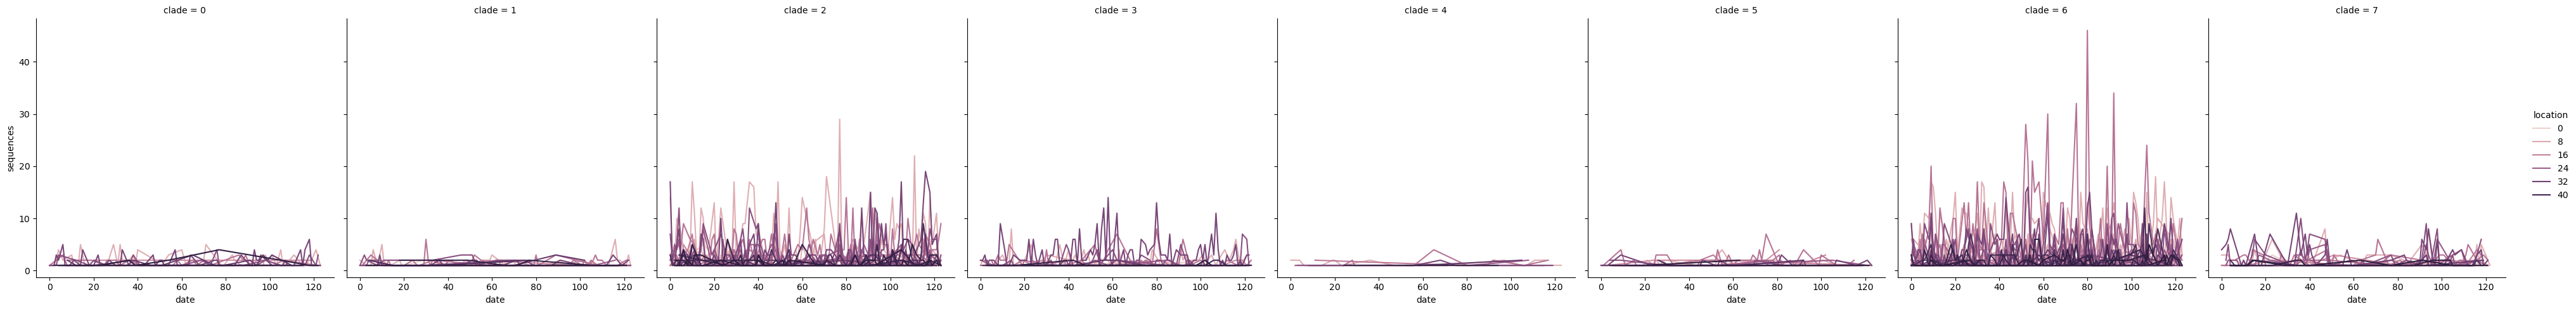

In [475]:
import seaborn as sns

#sns.lineplot(data=data, y = 'sequences', x = 'date', hue = 'clade')

# A lot of plots
#sns.relplot(data=data, x='date', y='sequences', row='clade', col='location', kind='line')
sns.relplot(data=data, x='date', y='sequences', col='clade', hue = 'location', kind='line')

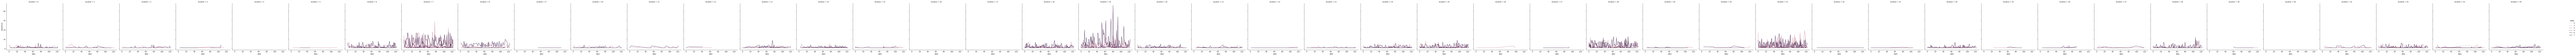

In [476]:
sns.relplot(data=data, x='date', y='sequences', hue='clade', col='location', kind='line')

In [479]:
data['location'].unique()

location
i64
0
1
2
3
4
…
40
41
42


$$
p_i = \frac{\exp{(\alpha_vl + \beta_vl t)}}{ \sum_{k=1}^K \exp{(\alpha_vl + \beta_vl t)}} 
$$

In [480]:
locations

['Alabama',
 'Alaska',
 'Arizona',
 'Arkansas',
 'California',
 'Colorado',
 'Connecticut',
 'Delaware',
 'Florida',
 'Georgia',
 'Hawaii',
 'Idaho',
 'Illinois',
 'Indiana',
 'Iowa',
 'Kansas',
 'Kentucky',
 'Louisiana',
 'Maine',
 'Maryland',
 'Massachusetts',
 'Michigan',
 'Minnesota',
 'Mississippi',
 'Missouri',
 'Montana',
 'Nebraska',
 'Nevada',
 'New Hampshire',
 'New Jersey',
 'New Mexico',
 'New York',
 'North Carolina',
 'North Dakota',
 'Ohio',
 'Oklahoma',
 'Oregon',
 'Pennsylvania',
 'Rhode Island',
 'South Carolina',
 'South Dakota',
 'Tennessee',
 'Texas',
 'Utah',
 'Vermont',
 'Virginia',
 'Washington',
 'West Virginia',
 'Wisconsin',
 'Wyoming']

In [481]:
time

array([108,  30,  75,  24,  70,  78,   8, 101,  92,  28,  14,  61,  80,
        98, 106,  25,  16,  58,  76,  68,  40, 119,   4,  35, 120, 118,
        11, 113,  79,   2,  20,  64,  81,  29,  31,  60, 112,  97,  67,
       114,   0,  91,  74,  63, 116, 107,  55,  26,   5,  46,  21,  10,
        44,   6,  12,   3,  77,  83,  53,  36,  71,  85,  42,  33,  65,
        66,  22,  62,  69,  52,  48,  93,  45,  50,  72,  95,  84,   1,
        59,  38, 110, 111, 104,  19,  73, 103, 100, 105,   9,  39,  13,
        41,  47,  32,  87,  51,  34,  43,  15,  90, 102,  94,  37,  18,
        99, 115,  75,  16,  68,  11,  20,  44,  67, 103,  13,  94,  54,
        80,  65,  37,  30,  70,  78,   8,  14,  61,  98,  25,  36, 116,
       107,  76,  55,  33,   5, 119,  35,  21, 120,  52,  48, 113,   2,
        50,  64,  31,  72,   6,  12,  97, 114,  77, 100,   9,  83,  32,
       102, 101,  74,  71,  40,  79,  60,  95,   1,   3, 111,  43,  73,
       105,  41,  87,  51,  18,  34, 109,  49,  17,  84,  57,  2

In [482]:
data

location,clade,date,sequences
i64,i64,i64,i64
39,3,115,1
39,6,82,1
39,6,65,1
39,6,110,1
39,6,60,2
…,…,…,…
5,2,115,1
5,2,4,1
5,2,93,1


In [483]:
data['clade'].unique()

clade
i64
0
1
2
3
4
5
6
7


In [484]:
data['date'].unique()


date
i64
0
1
2
3
4
…
119
120
121


In [485]:
df = pl.DataFrame(data)

# Pivot the DataFrame to get clade counts by date and location
pivot_df = df.pivot(values="sequences", columns="clade", index=["location", "date"], aggregate_function="sum")

# Fill missing values with 0 and convert to list format
pivot_df = pivot_df.fill_null(0)
pivot_df = pivot_df.with_columns([
    pl.concat_list(pivot_df.select(pl.exclude("location", "date"))).alias("clade_counts")
])

# Add total counts
pivot_df = pivot_df.with_columns([
    pivot_df.select(pl.exclude("location", "date", "clade_counts")).sum_horizontal().alias("total_counts")
])


/var/folders/15/gjw1xqz91mq9q73dqlw93_780000gn/T/ipykernel_85561/3038960788.py:4: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.
  pivot_df = df.pivot(values="sequences", columns="clade", index=["location", "date"], aggregate_function="sum")


In [486]:
pivot_df

location,date,3,6,2,7,5,0,4,1,clade_counts,total_counts
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,list[i64],i64
39,115,1,0,0,0,0,0,0,0,"[1, 0, … 0]",1
39,82,0,1,0,0,0,0,0,0,"[0, 1, … 0]",1
39,65,0,1,0,0,0,0,0,0,"[0, 1, … 0]",1
39,110,0,1,0,0,0,0,0,0,"[0, 1, … 0]",1
39,60,0,2,0,0,0,0,0,0,"[0, 2, … 0]",2
…,…,…,…,…,…,…,…,…,…,…,…
5,115,0,0,1,0,0,0,0,0,"[0, 0, … 0]",1
5,4,0,0,1,0,0,0,0,0,"[0, 0, … 0]",1
5,93,0,0,1,0,0,0,0,0,"[0, 0, … 0]",1


## Pre-process data into format for modeling

* Need to restructure data format to look like Multinomial counts for the below pyMC:
    * In particular, `Y` needs to look like `[[count1, count2, ..., countK], [count1, ..., countK]]` for each date.

In [324]:
# total_counts = np.array([i.sum() for i in Y])
# total_counts.shape == time.shape

In [487]:
# Prepare data for modeling
import pytensor

num_loc = len(pivot_df.select('location').unique())
num_diseases = len(data['clade'].unique())

time = pivot_df.get_column('date').to_numpy()
locations = pivot_df.get_column('location').to_numpy()
Y = np.vstack(pivot_df.get_column('clade_counts').to_numpy())
total_counts = np.array([i.sum() for i in Y]) # sum across multinomial observations for total counts each day/loc
# or
#total_counts = pivot_df.get_column('total_counts').to_numpy()

print(num_loc)
print(num_diseases)
print(time.shape)
print(locations.shape)
print(total_counts.shape)
print(Y.shape)


45
8
(2335,)
(2335,)
(2335,)
(2335, 8)


In [488]:
pivot_df

location,date,3,6,2,7,5,0,4,1,clade_counts,total_counts
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,list[i64],i64
39,115,1,0,0,0,0,0,0,0,"[1, 0, … 0]",1
39,82,0,1,0,0,0,0,0,0,"[0, 1, … 0]",1
39,65,0,1,0,0,0,0,0,0,"[0, 1, … 0]",1
39,110,0,1,0,0,0,0,0,0,"[0, 1, … 0]",1
39,60,0,2,0,0,0,0,0,0,"[0, 2, … 0]",2
…,…,…,…,…,…,…,…,…,…,…,…
5,115,0,0,1,0,0,0,0,0,"[0, 0, … 0]",1
5,4,0,0,1,0,0,0,0,0,"[0, 0, … 0]",1
5,93,0,0,1,0,0,0,0,0,"[0, 0, … 0]",1


In [489]:
coords = {"locations": locations, 
          "clades": clades,
          "time": time,
          "Y": Y}

In [ ]:
# Define the model
#with pm.Model(coords=coords) as variant_model:
with pm.Model() as variant_model:
    # Priors for unknown model parameters with better initial values
    alpha = pm.Normal('alpha', mu=0, sigma=3, shape=(num_loc, num_diseases-1), 
                      initval=np.random.rand(num_loc, num_diseases-1))
    beta = pm.Normal('beta', mu=0, sigma=3, shape=(num_loc, num_diseases-1),
                     initval=np.random.rand(num_loc, num_diseases-1))
    
    # Expected value of outcome (using the softmax link function)
    eta = alpha[locations] + beta[locations] * time[:, None]

    # Softmax eta to probability scale, shape K-1
    mu = pytensor.tensor.special.softmax(eta, axis=1)

    # Add K-th category. Had to softmax this result (mu_softmax) to avoid numerical issues.
    mu = pm.math.concatenate([mu, 1 - pm.math.sum(mu, axis=1, keepdims=True)], axis=1)  # Add the K-th category
    mu_softmax = pytensor.tensor.special.softmax(mu, axis=1)

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Multinomial('Y_obs', n=total_counts, p=mu_softmax, observed=Y)
    
    # Inference
    #trace = pm.sample(10000, tune=2000, cores=2)
    trace = pm.sample(10000, tune = 2000, cores = 4)

    # Perform posterior predictive sampling within the model's context
    posterior_predictive = pm.sample_posterior_predictive(trace, var_names=['alpha', 'beta', 'Y_obs'])

# Plot the results
pm.plot_trace(trace)

# Print summary of the trace
print(pm.summary(trace))

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Output()

In [375]:
alpha_post = posterior_predictive.posterior_predictive.alpha[0,:,:,:]
alpha_post.shape

(1000, 6, 7)

In [376]:
beta_post = posterior_predictive.posterior_predictive.beta[0,:,:,:]
beta_post.shape

(1000, 6, 7)

In [457]:
posterior_predictive.posterior_predictive.alpha.shape
posterior_predictive.posterior_predictive.alpha[0,:,:].shape
#posterior_predictive.posterior_predictive.alpha[0,:,:]

# 1000 Posterior draws of alpha (#locs by #clades)
posterior_predictive.posterior_predictive.alpha[0,:]

# 1000 Posterior draws of beta (#locs by #clades)
posterior_predictive.posterior_predictive.beta[0,:]

# 1000 Posterior draws of Y_obs (noice)
posterior_predictive.posterior_predictive.Y_obs[0,:].shape

# First sample of multinomial counts
posterior_predictive.posterior_predictive.Y_obs[0,1].shape
posterior_predictive.posterior_predictive.Y_obs[0,1]

<xarray.DataArray 'Y_obs' (Y_obs_dim_2: 504, Y_obs_dim_3: 8)> Size: 32kB
array([[ 3,  4,  4, ...,  6, 13,  7],
       [ 3,  5,  4, ...,  3, 15,  4],
       [ 5,  1,  0, ...,  1,  6,  3],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 1,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  1, ...,  0,  0,  0]])
Coordinates:
    chain        int64 8B 0
    draw         int64 8B 1
  * Y_obs_dim_2  (Y_obs_dim_2) int64 4kB 0 1 2 3 4 5 ... 498 499 500 501 502 503
  * Y_obs_dim_3  (Y_obs_dim_3) int64 64B 0 1 2 3 4 5 6 7

In [420]:
# Extract the model predictions
predicted_probs = posterior_predictive.posterior_predictive['Y_obs']
print(predicted_probs.shape)
print(predicted_probs[0].shape)
print(predicted_probs[0,0].shape)
predicted_probs[0,0]


(2, 1000, 504, 8)
(1000, 504, 8)
(504, 8)


<xarray.DataArray 'Y_obs' (Y_obs_dim_2: 504, Y_obs_dim_3: 8)> Size: 32kB
array([[ 4,  8,  4, ..., 12,  6,  3],
       [ 6,  8,  3, ..., 10,  6,  5],
       [ 2,  2,  4, ...,  6,  3,  2],
       ...,
       [ 0,  0,  1, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  1],
       [ 0,  0,  1, ...,  0,  0,  0]])
Coordinates:
    chain        int64 8B 0
    draw         int64 8B 0
  * Y_obs_dim_2  (Y_obs_dim_2) int64 4kB 0 1 2 3 4 5 ... 498 499 500 501 502 503
  * Y_obs_dim_3  (Y_obs_dim_3) int64 64B 0 1 2 3 4 5 6 7

In [412]:
Y

array([[ 2,  7, 32, ...,  0,  0,  1],
       [ 5,  2, 28, ...,  0,  0,  3],
       [ 2,  2, 13, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  0,  1,  0],
       [ 0,  0,  0, ...,  0,  1,  0],
       [ 0,  0,  0, ...,  0,  0,  1]])

In [411]:
predicted_probs[0,]

<xarray.DataArray 'Y_obs' (draw: 1000, Y_obs_dim_2: 504, Y_obs_dim_3: 8)> Size: 32MB
array([[[ 4,  8,  4, ..., 12,  6,  3],
        [ 6,  8,  3, ..., 10,  6,  5],
        [ 2,  2,  4, ...,  6,  3,  2],
        ...,
        [ 0,  0,  1, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  1],
        [ 0,  0,  1, ...,  0,  0,  0]],

       [[ 3,  4,  4, ...,  6, 13,  7],
        [ 3,  5,  4, ...,  3, 15,  4],
        [ 5,  1,  0, ...,  1,  6,  3],
        ...,
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 1,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  1, ...,  0,  0,  0]],

       [[10,  7,  4, ...,  4,  4,  6],
        [ 3, 16,  5, ...,  7,  1,  1],
        [ 0,  7,  4, ...,  1,  2,  2],
        ...,
...
        ...,
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  1, ...,  0,  0,  0],
        [ 0,  0,  1, ...,  0,  0,  0]],

       [[13,  6,  7, ...,  4,  7,  5],
        [ 8,  7,  3, ...,  6,  7,  6],
        [ 9,  4,  2, ...,  1,  2,  0],
        ...,
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  1,  0,  0]],

       [[ 7,  5, 14, ...,  3,  1,  3],
        [ 4,  3, 14, ...,  2,  4,  8],
        [ 2,  4,  7, ...,  2,  2,  1],
        ...,
        [ 0,  0,  0, ...,  0,  0,  1],
        [ 0,  0,  0, ...,  1,  0,  0],
        [ 0,  0,  1, ...,  0,  0,  0]]])
Coordinates:
    chain        int64 8B 0
  * draw         (draw) int64 8kB 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
  * Y_obs_dim_2  (Y_obs_dim_2) int64 4kB 0 1 2 3 4 5 ... 498 499 500 501 502 503
  * Y_obs_dim_3  (Y_obs_dim_3) int64 64B 0 1 2 3 4 5 6 7

In [444]:
predicted_probs[0, :, :, :].mean(axis=1)

<xarray.DataArray 'Y_obs' (draw: 1000, Y_obs_dim_3: 8)> Size: 64kB
array([[1.16666667, 1.24603175, 1.18452381, ..., 2.5218254 , 1.14484127,
        1.20436508],
       [1.12698413, 1.15277778, 1.2797619 , ..., 2.57142857, 1.78571429,
        1.24206349],
       [1.15079365, 1.74603175, 1.93055556, ..., 1.25198413, 1.18253968,
        1.16666667],
       ...,
       [1.23412698, 1.14285714, 1.24603175, ..., 2.25396825, 1.96428571,
        1.20833333],
       [2.28373016, 1.82738095, 1.22420635, ..., 1.28571429, 1.3968254 ,
        1.09920635],
       [1.9702381 , 1.22420635, 1.81150794, ..., 1.68253968, 1.30357143,
        1.27579365]])
Coordinates:
    chain        int64 8B 0
  * draw         (draw) int64 8kB 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
  * Y_obs_dim_3  (Y_obs_dim_3) int64 64B 0 1 2 3 4 5 6 7

In [388]:
predicted_probs[0, :, :, 3]

<xarray.DataArray 'Y_obs' (draw: 1000, Y_obs_dim_2: 504)> Size: 4MB
array([[5, 5, 1, ..., 0, 0, 0],
       [4, 4, 2, ..., 1, 0, 0],
       [7, 9, 3, ..., 1, 0, 1],
       ...,
       [5, 2, 2, ..., 0, 0, 0],
       [1, 5, 1, ..., 0, 1, 0],
       [6, 5, 2, ..., 0, 0, 0]])
Coordinates:
    chain        int64 8B 0
  * draw         (draw) int64 8kB 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
  * Y_obs_dim_2  (Y_obs_dim_2) int64 4kB 0 1 2 3 4 5 ... 498 499 500 501 502 503
    Y_obs_dim_3  int64 8B 3

In [385]:

import pandas as pd

# Convert the predicted data to a DataFrame for plotting
predicted_data = pd.DataFrame({
    'time': time,
    'location': locations,
    'clade_1': predicted_probs[0, :, :, 0].mean(axis=1),
    'clade_2': predicted_probs[0, :, :, 1].mean(axis=1),
    'clade_3': predicted_probs[0, :, :, 2].mean(axis=1),
    'clade_4': predicted_probs[0, :, :, 3].mean(axis=1),
    'clade_5': predicted_probs[0, :, :, 4].mean(axis=1),
    'clade_6': predicted_probs[0, :, :, 5].mean(axis=1),
    'clade_7': predicted_probs[0, :, :, 6].mean(axis=1)
})

# Melt the predicted DataFrame for easier plotting with seaborn
predicted_data_melted = predicted_data.melt(id_vars=['time', 'location'], value_vars=['clade_1', 'clade_2', 'clade_3', 
                                                                                      'clade_4','clade_5','clade_6','clade_7'],
                                            var_name='clade', value_name='predicted_count')

# Plot the response counts over time for each location using a faceted grid without shaded regions
g = sns.FacetGrid(data_melted, col="location", hue="clade", col_wrap=3, height=4)
g.map(sns.lineplot, "time", "count", marker="o", ci=None)
g.map(sns.lineplot, "time", "predicted_count", data=predicted_data_melted, linestyle="--", ci=None)
g.add_legend()
g.set_axis_labels("Time", "Count")
g.set_titles("Location {col_name}")
plt.show()

ValueError: All arrays must be of the same length

In [358]:
type(posterior_predictive)

arviz.data.inference_data.InferenceData

In [359]:
variant_model.basic_RVs

[alpha, beta, Y_obs]

In [360]:
variant_model.observed_RVs

[Y_obs]

In [361]:
variant_model.free_RVs

[alpha, beta]

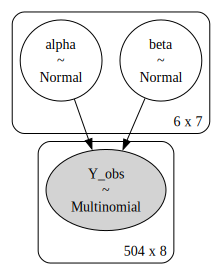

In [362]:
variant_model.to_graphviz()

/opt/anaconda3/envs/asper_pymc/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


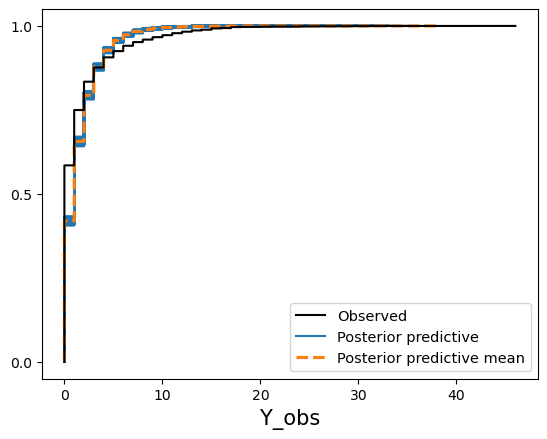

<Axes: xlabel='Y_obs'>

In [343]:
# Extract the model predictions
az.plot_ppc(posterior_predictive, show=True, kind = "cumulative")

In [ ]:
# Convert the predicted data to a DataFrame for plotting
predicted_data = pd.DataFrame({
    'time': time,
    'location': locations,
    'clade_1': predicted_probs[:, :, 0].mean(axis=1),
    'clade_2': predicted_probs[:, :, 1].mean(axis=1),
    'clade_3': predicted_probs[:, :, 2].mean(axis=1)
})